In [2]:
!pip install sumolib traci

  Obtaining dependency information for sumolib from https://files.pythonhosted.org/packages/26/a4/3cd2c6a5243b7790fbe4376e77671fdbe0ea6c37934013701b424d181b44/sumolib-1.21.0-py3-none-any.whl.metadata
  Obtaining dependency information for traci from https://files.pythonhosted.org/packages/2d/ad/6f0b71470069d86f26f6954ea706da31988232565693f62c5a310636a215/traci-1.21.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.9/149.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 2.5 MB/s eta 0:00:0031m1.2 MB/s eta 0:00:01


In [18]:
import xml.etree.ElementTree as ET
import random

def apply_lane_and_lateral_noise(input_file, output_file, max_lanes, lateral_offset_range):
    tree = ET.parse(input_file)
    root = tree.getroot()

    for vehicle in root.findall("vehicle"):
        vehicle_id = vehicle.get("id")
        if "gps" in vehicle_id:  # Apply changes only to GPS vehicles
            # Detect if the road is multi-lane or single-lane (this assumes network knowledge)
            random_lane = str(random.randint(0, max_lanes - 1)) if max_lanes > 1 else "0"

            # Set lane for multi-lane roads
            vehicle.set("departLane", random_lane)

            # For single-lane roads, simulate lateral offset by adding custom metadata
            if max_lanes == 1:
                lateral_offset = random.uniform(*lateral_offset_range)
                lateral_param = ET.SubElement(vehicle, "param", {
                    "key": "lateralOffset",
                    "value": f"{lateral_offset:.2f}"
                })

    # Write the updated XML to the output file
    tree.write(output_file, encoding="UTF-8", xml_declaration=True)
    print(f"Modified routes written to {output_file}")

# Parameters
input_file = "campus(delay).rou.xml"  # Replace with your input file
output_file = "campus_with_noise.rou.xml"  # Replace with your desired output file
max_lanes = 1  # Set the number of lanes per road segment; adjust as needed
lateral_offset_range = (-0.5, 0.5)  # Lateral offset in meters for single-lane roads

# Apply the modifications
apply_lane_and_lateral_noise(input_file, output_file, max_lanes, lateral_offset_range)


Modified routes written to campus_with_noise.rou.xml


In [20]:
import traci

traci.start(["sumo", "-c", "campus.sumocfg"])

step = 0
collision_events = []

while step < 10000:  # Simulate for a specific number of steps
    traci.simulationStep()
    collisions = traci.simulation.getCollidingVehiclesIDList()
    if collisions:
        collision_events.append((step, collisions))
    step += 1

traci.close()

print("Collisions detected:", collision_events)


 Retrying in 1 seconds


Step #10000.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 184 ACT 0 BUF 0)                  
Collisions detected: []


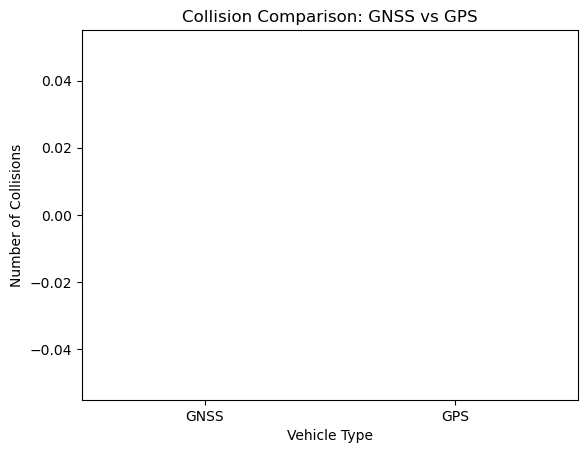

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def detect_near_misses(vehicle_positions, threshold=2.0):
    near_misses = []
    for timestep, positions in vehicle_positions.items():
        for id1, pos1 in positions.items():
            for id2, pos2 in positions.items():
                if id1 != id2:
                    distance = np.sqrt((pos1["x"] - pos2["x"])**2 + (pos1["y"] - pos2["y"])**2)
                    if distance < threshold:
                        near_misses.append((timestep, id1, id2, distance))
    return near_misses

labels = ["GNSS", "GPS"]
collision_counts = [len([e for e in collision_events if "gnss" in e[1]]), 
                    len([e for e in collision_events if "gps" in e[1]])]

plt.bar(labels, collision_counts, color=["green", "red"])
plt.xlabel("Vehicle Type")
plt.ylabel("Number of Collisions")
plt.title("Collision Comparison: GNSS vs GPS")
plt.show()


In [43]:
import os

def parse_scalar_file(scalar_file):
    metrics = {}
    with open(scalar_file, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        line = line.strip()
        if line.startswith("scalar"):
            parts = line.split()
            if len(parts) >= 4:
                node = parts[1]  # e.g., World.node[48].wlan[0].mac
                metric_name = parts[2]  # e.g., rcvdPkFromLL:count
                try:
                    value = float(parts[3])  # Convert the value to a float
                except ValueError:
                    # Skip non-numeric values
                    continue
                
                if node not in metrics:
                    metrics[node] = {}
                metrics[node][metric_name] = value

    return metrics


    return metrics

def calculate_pdr(metrics):
    pdrs = {}
    for node, data in metrics.items():
        packets_sent = data.get("sentDownPk:count", 0)
        packets_received = data.get("rcvdPkFromLL:count", 0)

        if packets_sent > 0:
            pdr = (packets_received / packets_sent) * 100
        else:
            pdr = 0  # No packets sent; PDR is 0%

        # Clamp PDR to a maximum of 100%
        pdrs[node] = min(pdr, 100)
    return pdrs

def calculate_latency(vectors):
    sent_times = []
    received_times = []
    latencies = []

    for vector_id, vector_data in vectors.items():
        if "sentDownPk" in vector_data["title"]:
            sent_times = [time for time, _ in vector_data["data"]]
        elif "rcvdPkFromHL" in vector_data["title"]:
            received_times = [time for time, _ in vector_data["data"]]

    if not sent_times or not received_times:
        print("Warning: Missing sent or received packet data.")
        return []

    # Match sent and received times
    for sent_time, received_time in zip(sent_times, received_times):
        latencies.append(received_time - sent_time)

    return latencies

# Debugging to confirm data
def debug_vectors(vectors):
    print("Available Vector Titles:")
    for vector_id, vector_data in vectors.items():
        print(f"Vector {vector_id}: {vector_data['title']}")

# Example Usage
vector_file = "results/General-#0.vec"
vectors = parse_vector_file(vector_file)

# Debug vector titles
debug_vectors(vectors)

# Calculate latencies
latencies = calculate_latency(vectors)

print("Latencies (s):")
print(latencies)

# Example usage
scalar_file = "results/General-#0.sca"

# Parse scalar file for PDR
scalar_metrics = parse_scalar_file(scalar_file)
pdrs = calculate_pdr(scalar_metrics)

# Output results
print("Packet Delivery Rates (PDR):")
for node, pdr in pdrs.items():
    print(f"{node}: {pdr * 100:.2f}%")



Available Vector Titles:
Vector 0: ETV
Vector 1: ETV
Vector 2: ETV
Vector 3: ETV
Vector 4: ETV
Vector 5: ETV
Vector 6: ETV
Vector 7: ETV
Vector 8: ETV
Vector 9: ETV
Vector 10: ETV
Vector 11: ETV
Vector 12: ETV
Vector 13: ETV
Vector 14: ETV
Vector 15: ETV
Vector 16: ETV
Vector 17: ETV
Vector 18: ETV
Vector 19: ETV
Vector 20: ETV
Vector 21: ETV
Vector 22: ETV
Vector 23: ETV
Vector 24: ETV
Vector 25: ETV
Vector 26: ETV
Vector 27: ETV
Vector 28: ETV
Vector 29: ETV
Vector 30: ETV
Vector 31: ETV
Vector 32: ETV
Vector 33: ETV
Vector 34: ETV
Vector 35: ETV
Vector 36: ETV
Vector 37: ETV
Vector 38: ETV
Vector 39: ETV
Vector 40: ETV
Vector 41: ETV
Vector 42: ETV
Vector 43: ETV
Vector 44: ETV
Vector 45: ETV
Vector 46: ETV
Vector 47: ETV
Vector 48: ETV
Vector 49: ETV
Vector 50: ETV
Vector 51: ETV
Vector 52: ETV
Vector 53: ETV
Vector 54: ETV
Vector 55: ETV
Vector 56: ETV
Vector 57: ETV
Vector 58: ETV
Vector 59: ETV
Vector 60: ETV
Vector 61: ETV
Vector 62: ETV
Vector 63: ETV
Vector 64: ETV
Vector 65:

ValueError: not enough values to unpack (expected 2, got 1)